In [1]:
import tensorflow as tf
import tensorflow_io as tfio
from efficientnet.tfkeras import EfficientNetB3

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import glob
from sklearn.model_selection import train_test_split
import os

In [3]:
# Hyper params
learning_rate = 1e-4
epochs = 200
batch_size = 64

# Build Model

In [4]:
effnet_model = EfficientNetB3(weights='imagenet', include_top=True)

In [5]:
embed_input = tf.keras.layers.Input(shape=(1000,))

# Encoder input
encoder_input = tf.keras.layers.Input(shape=(256, 256, 1))
encoder = tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=(2, 2))(encoder_input)
encoder = tf.keras.layers.Activation('relu')(encoder)
encoder = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(encoder)
encoder = tf.keras.layers.Activation('relu')(encoder)
encoder = tf.keras.layers.Conv2D(128, (3, 3), padding='same', strides=(2, 2))(encoder)
encoder = tf.keras.layers.Activation('relu')(encoder)
encoder = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(encoder)
encoder = tf.keras.layers.Activation('relu')(encoder)
encoder = tf.keras.layers.Conv2D(256, (3, 3), padding='same', strides=(2, 2))(encoder)
encoder = tf.keras.layers.Activation('relu')(encoder)
encoder = tf.keras.layers.Conv2D(512, (3, 3), padding='same')(encoder)
encoder = tf.keras.layers.Activation('relu')(encoder)
encoder = tf.keras.layers.Conv2D(512, (3, 3), padding='same')(encoder)
encoder = tf.keras.layers.Activation('relu')(encoder)
encoder = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(encoder)
encoder = tf.keras.layers.Activation('relu')(encoder)

# Fusion
fusion_output = tf.keras.layers.RepeatVector(32 * 32)(embed_input)
fusion_output = tf.keras.layers.Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = tf.keras.layers.concatenate([encoder, fusion_output], axis=3)
fusion_output = tf.keras.layers.Conv2D(256, (1, 1), padding='same')(fusion_output)
fusion_output = tf.keras.layers.Activation('relu')(fusion_output)

# Decoder
decoder_output = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(fusion_output)
decoder_output = tf.keras.layers.Activation('relu')(decoder_output)
decoder_output = tf.keras.layers.UpSampling2D((2, 2))(decoder_output)
decoder_output = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(decoder_output)
decoder_output = tf.keras.layers.Activation('relu')(decoder_output)
decoder_output = tf.keras.layers.UpSampling2D((2, 2))(decoder_output)
decoder_output = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(decoder_output)
decoder_output = tf.keras.layers.Activation('relu')(decoder_output)
decoder_output = tf.keras.layers.Conv2D(16, (3, 3), padding='same')(decoder_output)
decoder_output = tf.keras.layers.Activation('relu')(decoder_output)
decoder_output = tf.keras.layers.Conv2D(2, (3, 3), padding='same')(decoder_output)
decoder_output = tf.keras.layers.Activation('tanh')(decoder_output)
decoder_output = tf.keras.layers.UpSampling2D((2, 2))(decoder_output)

model = tf.keras.models.Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

In [6]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 128 73856       activation[0][0]                 
_______________________________________________________________________________________

In [7]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate))

# Load Data

In [8]:
def get_data(image_path):
    byte_img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(byte_img)
    img_norm = tf.cast(img, tf.float32)
    img_norm = img_norm / 255.
    
    img = tf.image.resize(img, (300, 300))
    img = img / 255.
    img_expanded = tf.expand_dims(img, axis=0)
    embeddings = tf.squeeze(effnet_model(img_expanded), axis=0)
    
    lab_img = tfio.experimental.color.rgb_to_lab(img_norm)
    
    l_img = tf.expand_dims(lab_img[:, :, 0], axis=2)
    ab_img = lab_img[:, :, 1:] / 128.
    
    return {'input_1': l_img, 'input_2': embeddings}, ab_img

In [9]:
images = glob.glob('data/images/Train/*.jpg')

In [10]:
train_images, validation_images = train_test_split(images, test_size=0.4, random_state=2021)
validation_images, test_images = train_test_split(validation_images, test_size=0.5, random_state=2021)

In [11]:
train_data = tf.data.Dataset.from_tensor_slices(train_images)
train_data = train_data.map(get_data)
train_data = train_data.batch(batch_size)
train_data = train_data.shuffle(len(train_images))
train_data = train_data.cache()
train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

validation_data = tf.data.Dataset.from_tensor_slices(validation_images)
validation_data = validation_data.map(get_data)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.cache()
validation_data = validation_data.prefetch(tf.data.experimental.AUTOTUNE)

# Train

In [12]:
# Specify callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model/colorize_effnet-{epoch:02d}-{val_loss:.2f}.hdf5",
    monitor='val_loss', patience=5, save_best_only=True
)

In [13]:
history = model.fit(
    train_data, epochs=epochs, validation_data=validation_data,
    callbacks=[model_checkpoint]
)

Epoch 1/200
79/79 [==============================] - 159s 2s/step - loss: 0.0106 - val_loss: 0.0107
Epoch 2/200
79/79 [==============================] - 40s 504ms/step - loss: 0.0103 - val_loss: 0.0106
Epoch 3/200
79/79 [==============================] - 40s 510ms/step - loss: 0.0102 - val_loss: 0.0105
Epoch 4/200
79/79 [==============================] - 41s 516ms/step - loss: 0.0101 - val_loss: 0.0104
Epoch 5/200
79/79 [==============================] - 41s 520ms/step - loss: 0.0099 - val_loss: 0.0103
Epoch 6/200
79/79 [==============================] - 41s 522ms/step - loss: 0.0096 - val_loss: 0.0101
Epoch 7/200
79/79 [==============================] - 41s 523ms/step - loss: 0.0093 - val_loss: 0.0101
Epoch 8/200
79/79 [==============================] - 41s 524ms/step - loss: 0.0090 - val_loss: 0.0100
Epoch 9/200
79/79 [==============================] - 41s 523ms/step - loss: 0.0089 - val_loss: 0.0101
Epoch 10/200
79/79 [==============================] - 41s 523ms/step - loss: 0.0087 

79/79 [==============================] - 41s 516ms/step - loss: 0.0022 - val_loss: 0.0121
Epoch 158/200
79/79 [==============================] - 41s 516ms/step - loss: 0.0022 - val_loss: 0.0117
Epoch 159/200
79/79 [==============================] - 41s 515ms/step - loss: 0.0022 - val_loss: 0.0121
Epoch 160/200
79/79 [==============================] - 41s 516ms/step - loss: 0.0021 - val_loss: 0.0120
Epoch 161/200
79/79 [==============================] - 41s 516ms/step - loss: 0.0021 - val_loss: 0.0122
Epoch 162/200
79/79 [==============================] - 41s 516ms/step - loss: 0.0020 - val_loss: 0.0124
Epoch 163/200
79/79 [==============================] - 41s 517ms/step - loss: 0.0020 - val_loss: 0.0122
Epoch 164/200
79/79 [==============================] - 41s 515ms/step - loss: 0.0020 - val_loss: 0.0121
Epoch 165/200
79/79 [==============================] - 41s 516ms/step - loss: 0.0020 - val_loss: 0.0124
Epoch 166/200
79/79 [==============================] - 41s 516ms/step - loss: 

In [14]:
if not os.path.exists('model/'):
    os.makedirs('model')
    
model.save('model/effnet_colorizer.h5')

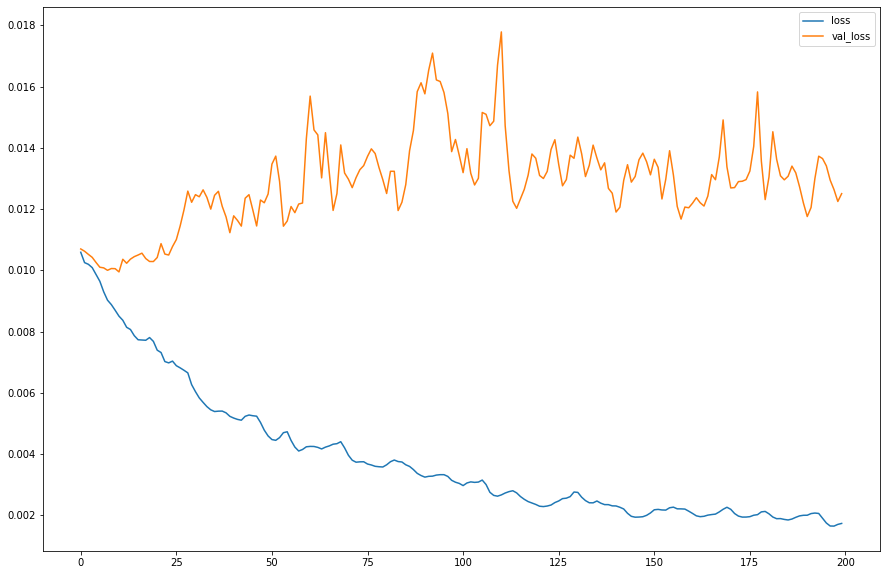

In [15]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()

# Evaluate

In [16]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if name == 'l_img':
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)
    plt.show()

In [17]:
def fill_lab_img(img_shape, l_color, ab_color):
    lab_image = np.zeros(img_shape)
    lab_image[:, :, 0] = l_color
    lab_image[:, :, 1:] = ab_color
    
    return lab_image

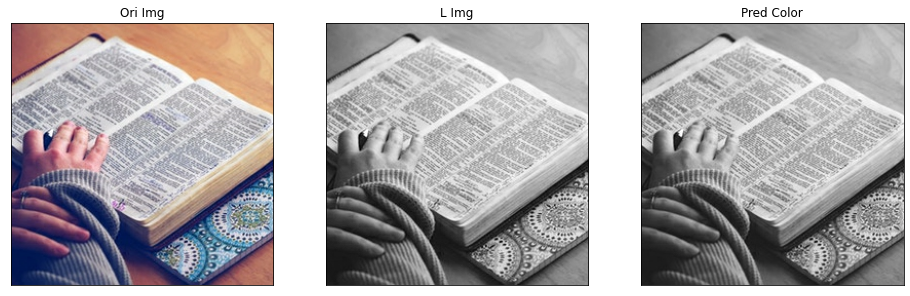

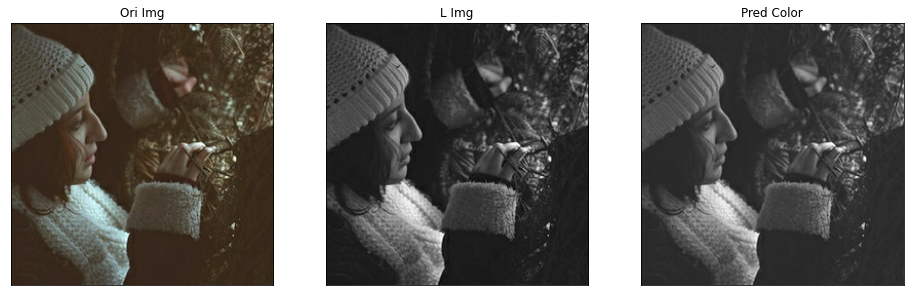

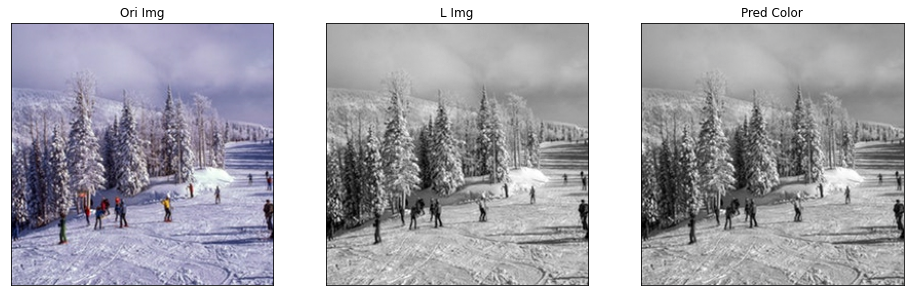

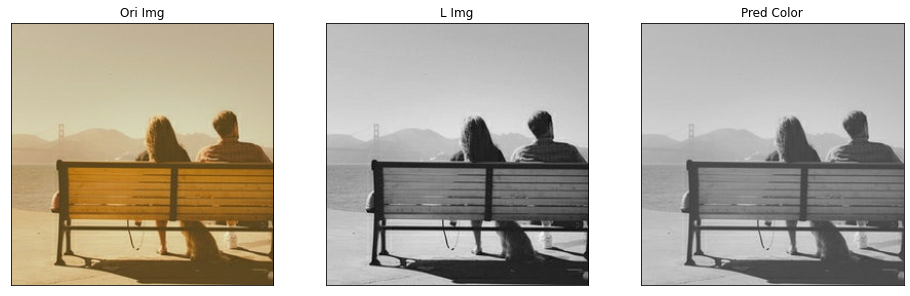

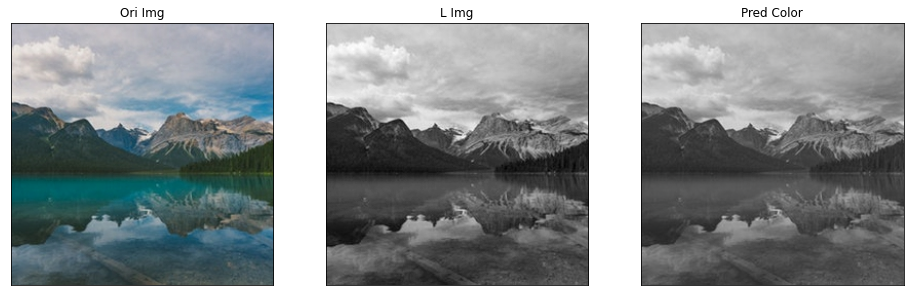

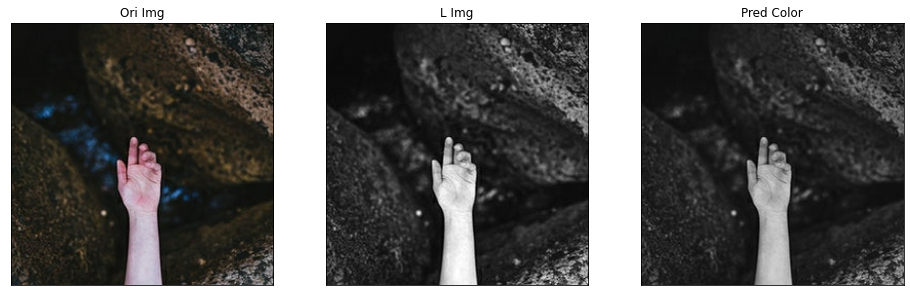

<Figure size 432x288 with 0 Axes>

In [18]:
for test_image in np.random.choice(test_images, size=6):
    img = tf.io.decode_jpeg(tf.io.read_file(test_image))
    img_norm = tf.cast(img, tf.float32)
    img_norm = img_norm / 255.
    
    lab_img = tfio.experimental.color.rgb_to_lab(img_norm)
    l_img = lab_img[:, :, 0]
    
    img_resized = tf.image.resize(img, (300, 300))
    img_resized = img_resized / 255.
    embeddings = effnet_model.predict(tf.expand_dims(img_resized, axis=0))
    pred_ab = model.predict([tf.expand_dims(l_img, axis=0), embeddings])
    
    lab_image = fill_lab_img(img.shape, l_img, pred_ab * 128)
    colorized_image = tfio.experimental.color.lab_to_rgb(lab_image)
    
    visualize(
        ori_img=img, l_img=l_img, pred_color=colorized_image
    )
    
plt.tight_layout()